In [1]:
from src.const import BASE_DATA_PATH
from src.db.db_session import init_db

init_db()

2024-11-22 15:22:43,168 - src.db.db_session - INFO - init sqlite db /home/rsoleyma/projects/platforms-clients/data/db_safe.sqlite


In [2]:
from src.db.db_models import Base
from src.db.db_mgmt import DatabaseConfig, DatabaseManager

conf = DatabaseConfig("sqlite", (BASE_DATA_PATH / "db.sqlite").as_posix(), Base)
db = DatabaseManager(conf)

In [3]:
from src.db.db_models import DBPost
from typing import Optional
from sqlalchemy import select


def get_posts(platform: str,
              task_name: Optional[str] = None,
              task_step: Optional[int] = None) -> list[DBPost]:
    with db.get_session() as session:
        # Start with a base query
        query = select(DBPost)

        # Platform is required
        query = query.where(DBPost.platform == platform)

        # If task_name is provided, add it to the query
        if task_name is not None:
            query = query.where(DBPost.collection_task_name == task_name)

        # Execute the query and return the results
        result = session.execute(query)
        return result.scalars().all()


all = get_posts("youtube")

In [4]:
len(all)

10428

In [8]:
from src.db.db_models import DBCollectionTask
from typing import Iterable
from pydantic import BaseModel, Field, AliasPath, create_model
from csv import DictWriter
from pathlib import Path

paths = ["id.videoId", "collecion_task", "snippet.publishedAt", "snippet.title", "snippet.description",
         "contentDetails.duration", "status.license", "statistics.viewCount", "statistics.likeCount",
         "statistics.favoriteCount", "statistics.commentCount", "topicDetails.topicCategories", "collection_task"]


def to_snake_case(name: str) -> str:
    return ''.join(['_' + c.lower() if c.isupper() else c for c in name]).lstrip('_')


# Create field definitions
fields = {
    to_snake_case(path.split('.')[-1]): (
        int if 'count' in path.lower() else
        list[str] if 'categories' in path.lower() else
        str,
        Field(default=None, validation_alias=AliasPath(*path.split('.')))
    )
    for path in paths
}
fields["video_url"] = str, Field(default=None)
# Create the model
PostSimple = create_model('PostSimple', **fields)


col_tasks: dict[int, str] = {}

with db.get_session() as session:
    for ct in session.execute(select(DBCollectionTask)).scalars():
        col_tasks[ct.id] = ct.task_name


def save_pydantic_model_to_csv(models: Iterable[BaseModel], filepath: str | Path, **kwargs) -> None:
    """Save Pydantic model to CSV file using DictWriter."""
    filepath = Path(filepath)
    filepath.parent.mkdir(parents=True, exist_ok=True)

    data = [m.model_dump(**kwargs) for m in models]

    with open(filepath, 'w', newline='', encoding="utf-8") as f:
        fieldnames = data[0].keys()
        writer = DictWriter(f, fieldnames=fieldnames)
        print(fieldnames)
        writer.writeheader()
        writer.writerows(data)


def db_obj_yielder(query_iter: Iterable[DBPost], accepted_tasks_names: list[str] = None):
    for obj in query_iter:
        task_name = col_tasks[obj.collection_task_id]
        if accepted_tasks_names and task_name not in accepted_tasks_names:
            continue
        yield PostSimple.model_validate(obj.content | {
            "collection_task": task_name,
            "video_url": f"https://www.youtube.com/v/{obj.platform_id}"
        })


with db.get_session() as session:
    gen = session.execute(select(DBPost)).scalars()

    accepted_cols= []
    for col_task in col_tasks.values():
        if "2022_en_all_months" in col_task:
            accepted_cols.append(col_task)
    gen2 = db_obj_yielder(gen,accepted_cols)
    save_pydantic_model_to_csv(gen2, "db_safe.csv")

dict_keys(['video_id', 'collecion_task', 'published_at', 'title', 'description', 'duration', 'license', 'view_count', 'like_count', 'favorite_count', 'comment_count', 'topic_categories', 'collection_task', 'video_url'])


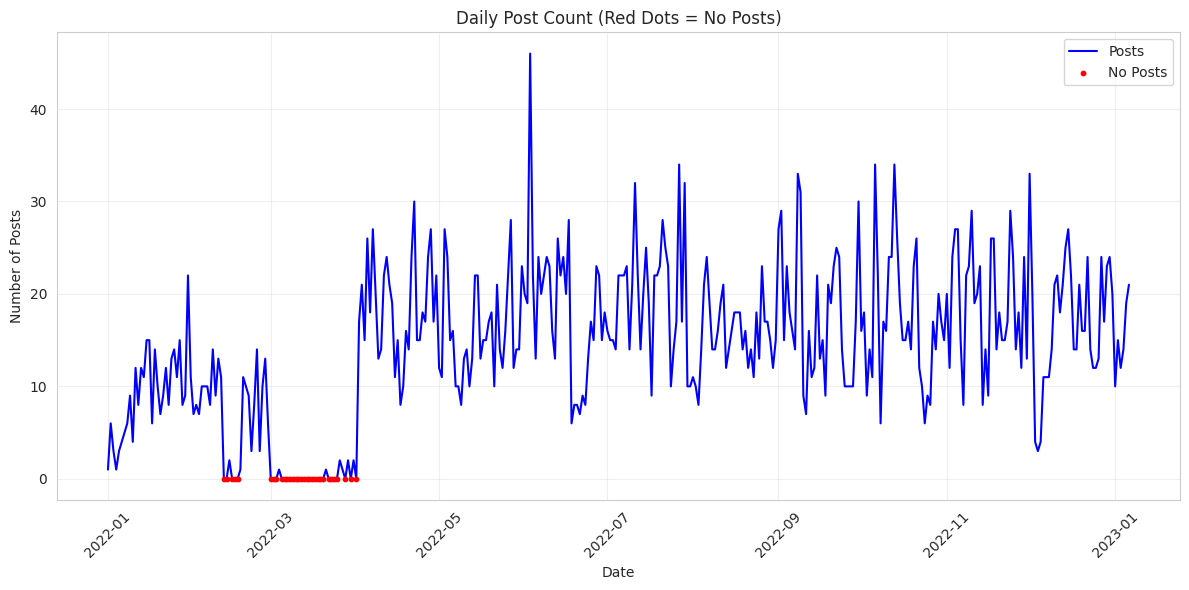

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_daily_items(csv_path):
    # Read CSV and convert publishedAt to datetime
    df = pd.read_csv(csv_path)
    df['published_at'] = pd.to_datetime(df['published_at'])

    # Create daily counts
    daily_counts = df.groupby(df['published_at'].dt.date).size()
    # Create complete date range

    date_range = pd.date_range(
        start=daily_counts.index.min(),
        end=daily_counts.index.max(),
        freq='D'
    )

    # Reindex to include all dates, filling missing with 0
    daily_counts = daily_counts.reindex(date_range, fill_value=0)

    # Plot
    plt.figure(figsize=(12, 6))

    # Plot main line
    sns.lineplot(data=daily_counts, color='blue', label='Posts')

    # Highlight days with zero posts
    zero_days = daily_counts[daily_counts == 0]
    if not zero_days.empty:
        plt.scatter(zero_days.index, zero_days.values,
                    color='red', s=10, label='No Posts',
                    zorder=5)  # zorder ensures points are on top

    # Customize plot
    plt.title('Daily Post Count (Red Dots = No Posts)')
    plt.xlabel('Date')
    plt.ylabel('Number of Posts')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    return plt

# Example usage:
plot = plot_daily_items('db_safe.csv')
plot.show()